In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from itertools import product

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
shops=reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/Classroom/인공지능 서비스 개발자 _ 강동1기/kaggle/data/shops.csv'))
sample=reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/Classroom/인공지능 서비스 개발자 _ 강동1기/kaggle/data/sample_submission.csv'))
test=reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/Classroom/인공지능 서비스 개발자 _ 강동1기/kaggle/data/test.csv'))
categ=reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/Classroom/인공지능 서비스 개발자 _ 강동1기/kaggle/data/item_categories.csv'))
items=reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/Classroom/인공지능 서비스 개발자 _ 강동1기/kaggle/data/items.csv'))

#테스트 용 데이터 프레임을 하나 따로 만들어준다.
test2 = test.copy()

Memory usage of dataframe is 0.00 MB --> 0.00 MB (Decreased by 38.6%)
Memory usage of dataframe is 3.27 MB --> 1.63 MB (Decreased by 50.0%)
Memory usage of dataframe is 4.90 MB --> 1.43 MB (Decreased by 70.8%)
Memory usage of dataframe is 0.00 MB --> 0.00 MB (Decreased by 39.9%)
Memory usage of dataframe is 0.51 MB --> 0.23 MB (Decreased by 54.2%)


데이터 전처리

In [5]:
merge=pd.merge(items,categ,on="item_category_id")
merge.info()

#item_category_id을 기준으로 items 및 item_categories 데이터 merge

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22170 entries, 0 to 22169
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_name           22170 non-null  object
 1   item_id             22170 non-null  int16 
 2   item_category_id    22170 non-null  int8  
 3   item_category_name  22170 non-null  object
dtypes: int16(1), int8(1), object(2)
memory usage: 584.6+ KB


In [6]:
merge=merge.sort_values(by=['item_category_id'],ascending=True)
merge
#item_category_id 기준으로 정렬

,item_name,item_id,item_category_id,item_category_name
20297,PC: Гарнитура HyperX Cloud Core игровая стерео...,5441,0,PC - Гарнитуры/Наушники
20298,Наушники PHILIPS SBC HC8680,16255,0,PC - Гарнитуры/Наушники
20299,Наушники RITMIX RH-120,16256,0,PC - Гарнитуры/Наушники
20300,Наушники RITMIX RH-124 Black,16257,0,PC - Гарнитуры/Наушники
20406,Pelican. Геймпад Nerf Wireless Controller PS2 ...,5740,1,Аксессуары - PS2
...,...,...,...,...
22157,Элемент питания DURACELL LR03-BC2,22087,83,Элементы питания
22156,Элемент питания DURACELL 6LR61 9V 1*BL,22086,83,Элементы питания
22155,Элемент питания DURACELL 123 A Ultra MP3 1*BL,22085,83,Элементы питания
22161,Элемент питания DURACELL TURBO LR 03 2*BL,22091,83,Элементы питания


In [7]:
merge.columns

Index(['item_name', 'item_id', 'item_category_id', 'item_category_name'], dtype='object')

In [8]:
#train=pd.read_csv('./data/sales_train.csv')
train=reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/Classroom/인공지능 서비스 개발자 _ 강동1기/kaggle/data/sales_train.csv'))
train.head()

Memory usage of dataframe is 134.39 MB --> 56.00 MB (Decreased by 58.3%)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000000,1.0
1,03.01.2013,0,25,2552,899.000000,1.0
2,05.01.2013,0,25,2552,899.000000,-1.0
3,06.01.2013,0,25,2554,1709.050049,1.0
4,15.01.2013,0,25,2555,1099.000000,1.0


In [9]:
train.isnull().sum()
#결측치 확인 >> 없다!

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [10]:
#train 중복처리
train.duplicated().sum()

6

In [11]:
#train 중복 삭제
train.drop_duplicates(subset= ["date","shop_id","item_id"], inplace=True)
len(train)

2935821

In [12]:
print(train)
print(test)
train=pd.merge(test,train,on=['item_id','shop_id'],how='left')
#item_id,shop_id(shop_id_x,shop_id_y 로 나뉘기때문에 같이 merge) 기준으로 train 및 test 데이터 merge
train

#merge 사용해서 test에는 없고 train 에만 있는 자료 삭제!

               date  date_block_num  shop_id  item_id   item_price  \
0        02.01.2013               0       59    22154   999.000000   
1        03.01.2013               0       25     2552   899.000000   
2        05.01.2013               0       25     2552   899.000000   
3        06.01.2013               0       25     2554  1709.050049   
4        15.01.2013               0       25     2555  1099.000000   
...             ...             ...      ...      ...          ...   
2935844  10.10.2015              33       25     7409   299.000000   
2935845  09.10.2015              33       25     7460   299.000000   
2935846  14.10.2015              33       25     7459   349.000000   
2935847  22.10.2015              33       25     7440   299.000000   
2935848  03.10.2015              33       25     7460   299.000000   

         item_cnt_day  
0                 1.0  
1                 1.0  
2                -1.0  
3                 1.0  
4                 1.0  
...            

,ID,shop_id,item_id,date,date_block_num,item_price,item_cnt_day
0,0,5,5037,21.09.2014,20.0,2599.0,1.0
1,0,5,5037,29.11.2014,22.0,2599.0,1.0
2,0,5,5037,28.12.2014,23.0,1999.0,1.0
3,0,5,5037,20.12.2014,23.0,1999.0,1.0
4,0,5,5037,02.01.2015,24.0,1999.0,1.0
...,...,...,...,...,...,...,...
1327218,214198,45,19648,NaN,NaN,NaN,NaN
1327219,214199,45,969,22.06.2014,17.0,549.0,1.0
1327220,214199,45,969,28.06.2014,17.0,549.0,2.0
1327221,214199,45,969,11.07.2014,18.0,549.0,1.0


In [13]:
train.isnull().sum()
#결측치 확인 >> 꽤 많네

ID                     0
shop_id                0
item_id                0
date              102796
date_block_num    102796
item_price        102796
item_cnt_day      102796
dtype: int64

In [14]:
train=train.dropna()
train
#결측치 다 삭제

,ID,shop_id,item_id,date,date_block_num,item_price,item_cnt_day
0,0,5,5037,21.09.2014,20.0,2599.0,1.0
1,0,5,5037,29.11.2014,22.0,2599.0,1.0
2,0,5,5037,28.12.2014,23.0,1999.0,1.0
3,0,5,5037,20.12.2014,23.0,1999.0,1.0
4,0,5,5037,02.01.2015,24.0,1999.0,1.0
...,...,...,...,...,...,...,...
1327217,214197,45,15757,22.02.2015,25.0,199.0,1.0
1327219,214199,45,969,22.06.2014,17.0,549.0,1.0
1327220,214199,45,969,28.06.2014,17.0,549.0,2.0
1327221,214199,45,969,11.07.2014,18.0,549.0,1.0


In [15]:
print(train)
print(test)
train=pd.merge(merge,train,on=['item_id'],how='left')
#item_id,shop_id 기준으로 train 및 test 데이터 merge
train

#merge 사용해서 test에는 없고 train 에만 있는 자료 삭제!

             ID  shop_id  item_id        date  date_block_num  item_price  \
0             0        5     5037  21.09.2014            20.0      2599.0   
1             0        5     5037  29.11.2014            22.0      2599.0   
2             0        5     5037  28.12.2014            23.0      1999.0   
3             0        5     5037  20.12.2014            23.0      1999.0   
4             0        5     5037  02.01.2015            24.0      1999.0   
...         ...      ...      ...         ...             ...         ...   
1327217  214197       45    15757  22.02.2015            25.0       199.0   
1327219  214199       45      969  22.06.2014            17.0       549.0   
1327220  214199       45      969  28.06.2014            17.0       549.0   
1327221  214199       45      969  11.07.2014            18.0       549.0   
1327222  214199       45      969  09.08.2014            19.0       549.0   

         item_cnt_day  
0                 1.0  
1                 1.0  
2  

,item_name,item_id,item_category_id,item_category_name,ID,shop_id,date,date_block_num,item_price,item_cnt_day
0,PC: Гарнитура HyperX Cloud Core игровая стерео...,5441,0,PC - Гарнитуры/Наушники,NaN,NaN,NaN,NaN,NaN,NaN
1,Наушники PHILIPS SBC HC8680,16255,0,PC - Гарнитуры/Наушники,NaN,NaN,NaN,NaN,NaN,NaN
2,Наушники RITMIX RH-120,16256,0,PC - Гарнитуры/Наушники,NaN,NaN,NaN,NaN,NaN,NaN
3,Наушники RITMIX RH-124 Black,16257,0,PC - Гарнитуры/Наушники,NaN,NaN,NaN,NaN,NaN,NaN
4,Pelican. Геймпад Nerf Wireless Controller PS2 ...,5740,1,Аксессуары - PS2,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1241876,Элемент питания DURACELL TURBO LR 03 2*BL,22091,83,Элементы питания,209689.0,45.0,19.06.2014,17.0,109.0,1.0
1241877,Элемент питания DURACELL TURBO LR 03 2*BL,22091,83,Элементы питания,209689.0,45.0,25.11.2014,22.0,109.0,1.0
1241878,Элемент питания DURACELL TURBO LR 03 2*BL,22091,83,Элементы питания,209689.0,45.0,30.12.2014,23.0,139.0,1.0
1241879,Элемент питания DURACELL TURBO LR 03 2*BL,22091,83,Элементы питания,209689.0,45.0,24.07.2015,30.0,179.0,1.0


In [16]:
train=train.dropna()
train
#결측치 다 삭제

,item_name,item_id,item_category_id,item_category_name,ID,shop_id,date,date_block_num,item_price,item_cnt_day
18,PS3: Контроллер игровой беспроводной черный (D...,5643,2,Аксессуары - PS3,27.0,5.0,10.04.2013,3.0,2390.0,1.0
19,PS3: Контроллер игровой беспроводной черный (D...,5643,2,Аксессуары - PS3,27.0,5.0,19.05.2013,4.0,2290.0,1.0
20,PS3: Контроллер игровой беспроводной черный (D...,5643,2,Аксессуары - PS3,27.0,5.0,12.07.2013,6.0,2390.0,1.0
21,PS3: Контроллер игровой беспроводной черный (D...,5643,2,Аксессуары - PS3,27.0,5.0,27.07.2013,6.0,2390.0,1.0
22,PS3: Контроллер игровой беспроводной черный (D...,5643,2,Аксессуары - PS3,27.0,5.0,16.11.2013,10.0,2490.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1241875,Элемент питания DURACELL TURBO LR 03 2*BL,22091,83,Элементы питания,209689.0,45.0,01.05.2014,16.0,109.0,1.0
1241876,Элемент питания DURACELL TURBO LR 03 2*BL,22091,83,Элементы питания,209689.0,45.0,19.06.2014,17.0,109.0,1.0
1241877,Элемент питания DURACELL TURBO LR 03 2*BL,22091,83,Элементы питания,209689.0,45.0,25.11.2014,22.0,109.0,1.0
1241878,Элемент питания DURACELL TURBO LR 03 2*BL,22091,83,Элементы питания,209689.0,45.0,30.12.2014,23.0,139.0,1.0


In [1]:
train_backup=train.copy()

NameError: ignored

In [17]:
train.columns

Index(['item_name', 'item_id', 'item_category_id', 'item_category_name', 'ID',
       'shop_id', 'date', 'date_block_num', 'item_price', 'item_cnt_day'],
      dtype='object')

In [18]:
#train=train.reindex(columns=['date', 'date_block_num','shop_id','item_name', 'item_id', 'item_category_id', 'item_category_name', 'item_price', 'item_cnt_day'])
#train
#column 순서 변경

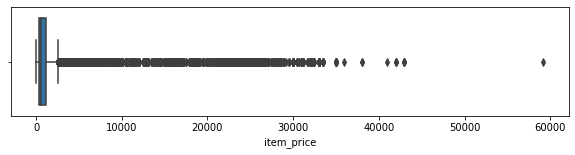

In [19]:
#이상치 제거
plt.figure(figsize=(10,2))
sns.boxplot(x=train.item_price)
#금액 가격 확인

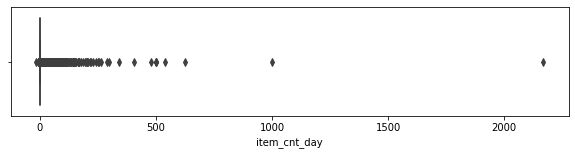

In [20]:
#이상치 제거
plt.figure(figsize=(10,2))
sns.boxplot(x=train.item_cnt_day)
#하루에 판매된 제품 수,,음수값? >> 그냥 둘지 말지? >> 음수는 일단 제거!

In [21]:
train.sort_values(['item_price'],ascending=False)[:10]
#상위 item_price 확인

,item_name,item_id,item_category_id,item_category_name,ID,shop_id,date,date_block_num,item_price,item_cnt_day
42870,Доставка (EMS),11365,9,Доставка товара,37350.0,12.0,17.09.2013,8.0,59200.0,1.0
49067,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",13403,16,Игровые консоли - XBOX ONE,20306.0,3.0,20.10.2015,33.0,42990.0,1.0
49075,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",13403,16,Игровые консоли - XBOX ONE,107006.0,42.0,23.10.2015,33.0,42990.0,1.0
49073,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",13403,16,Игровые консоли - XBOX ONE,66206.0,22.0,20.10.2015,33.0,42990.0,1.0
49069,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",13403,16,Игровые консоли - XBOX ONE,40706.0,12.0,29.10.2015,33.0,42990.0,1.0
49068,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",13403,16,Игровые консоли - XBOX ONE,40706.0,12.0,20.10.2015,33.0,41990.0,1.0
49074,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",13403,16,Игровые консоли - XBOX ONE,91706.0,18.0,22.10.2015,33.0,41990.0,1.0
49078,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",13403,16,Игровые консоли - XBOX ONE,183506.0,38.0,20.10.2015,33.0,41990.0,1.0
49070,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",13403,16,Игровые консоли - XBOX ONE,45806.0,28.0,22.10.2015,33.0,40991.0,1.0
49077,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",13403,16,Игровые консоли - XBOX ONE,107006.0,42.0,29.10.2015,33.0,37991.0,2.0


In [22]:
train.sort_values(['item_cnt_day'],ascending=False)[:50]
#상위 item_price 확인

,item_name,item_id,item_category_id,item_category_name,ID,shop_id,date,date_block_num,item_price,item_cnt_day
42774,Доставка до пункта выдачи (Boxberry),11373,9,Доставка товара,37296.0,12.0,28.10.2015,33.0,0.908714,2169.0
1147476,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71,"Подарки - Сумки, Альбомы, Коврики д/мыши",36160.0,12.0,15.01.2015,24.0,4.000000,1000.0
470883,"Grand Theft Auto V [PC, русские субтитры]",3731,30,Игры PC - Стандартные издания,35754.0,12.0,14.04.2015,27.0,1904.548096,624.0
42667,Доставка до пункта выдачи (Boxberry),11373,9,Доставка товара,37296.0,12.0,19.05.2015,28.0,155.192947,539.0
1150293,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71,"Подарки - Сумки, Альбомы, Коврики д/мыши",56560.0,25.0,28.06.2014,17.0,5.000000,501.0
1147477,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71,"Подарки - Сумки, Альбомы, Коврики д/мыши",36160.0,12.0,14.10.2015,33.0,4.000000,500.0
1147475,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71,"Подарки - Сумки, Альбомы, Коврики д/мыши",36160.0,12.0,19.12.2014,23.0,4.000000,500.0
344784,"Ведьмак 3: Дикая охота [PC, русская версия]",10209,28,Игры PC - Дополнительные издания,35874.0,12.0,19.05.2015,28.0,1499.000000,480.0
1151833,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71,"Подарки - Сумки, Альбомы, Коврики д/мыши",66760.0,24.0,15.03.2014,14.0,5.000000,405.0
41797,Доставка (по Москве),11370,9,Доставка товара,37341.0,12.0,19.05.2015,28.0,171.661804,343.0


In [23]:
train=train[(train.item_price>=0) & (train.item_price<40000)]
train=train[(train.item_cnt_day>=0) & (train.item_cnt_day<=300)]

#이상치 보고 잘라줌

In [24]:
train.sort_values(['item_id']).head()
#sales_train 의 item_id 를 확인. 같은 item_id 기준 shop_id 마다 item_price 가 다름

,item_name,item_id,item_category_id,item_category_name,ID,shop_id,date,date_block_num,item_price,item_cnt_day
717880,007: КООРДИНАТЫ «СКАЙФОЛЛ»,30,40,Кино - DVD,119887.0,53.0,08.09.2013,8.0,399.0,1.0
717318,007: КООРДИНАТЫ «СКАЙФОЛЛ»,30,40,Кино - DVD,48487.0,31.0,16.02.2013,1.0,399.0,12.0
717319,007: КООРДИНАТЫ «СКАЙФОЛЛ»,30,40,Кино - DVD,48487.0,31.0,24.02.2013,1.0,399.0,5.0
717320,007: КООРДИНАТЫ «СКАЙФОЛЛ»,30,40,Кино - DVD,48487.0,31.0,26.02.2013,1.0,399.0,2.0
717321,007: КООРДИНАТЫ «СКАЙФОЛЛ»,30,40,Кино - DVD,48487.0,31.0,27.02.2013,1.0,399.0,1.0


In [25]:
train

,item_name,item_id,item_category_id,item_category_name,ID,shop_id,date,date_block_num,item_price,item_cnt_day
18,PS3: Контроллер игровой беспроводной черный (D...,5643,2,Аксессуары - PS3,27.0,5.0,10.04.2013,3.0,2390.0,1.0
19,PS3: Контроллер игровой беспроводной черный (D...,5643,2,Аксессуары - PS3,27.0,5.0,19.05.2013,4.0,2290.0,1.0
20,PS3: Контроллер игровой беспроводной черный (D...,5643,2,Аксессуары - PS3,27.0,5.0,12.07.2013,6.0,2390.0,1.0
21,PS3: Контроллер игровой беспроводной черный (D...,5643,2,Аксессуары - PS3,27.0,5.0,27.07.2013,6.0,2390.0,1.0
22,PS3: Контроллер игровой беспроводной черный (D...,5643,2,Аксессуары - PS3,27.0,5.0,16.11.2013,10.0,2490.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1241875,Элемент питания DURACELL TURBO LR 03 2*BL,22091,83,Элементы питания,209689.0,45.0,01.05.2014,16.0,109.0,1.0
1241876,Элемент питания DURACELL TURBO LR 03 2*BL,22091,83,Элементы питания,209689.0,45.0,19.06.2014,17.0,109.0,1.0
1241877,Элемент питания DURACELL TURBO LR 03 2*BL,22091,83,Элементы питания,209689.0,45.0,25.11.2014,22.0,109.0,1.0
1241878,Элемент питания DURACELL TURBO LR 03 2*BL,22091,83,Элементы питания,209689.0,45.0,30.12.2014,23.0,139.0,1.0


matrix 빈틀 만들기

In [26]:
#test에는 있는데 train에는 없는 item_id 가 있다
#>>이 데이터 들에 대해서는 train 에 추가 후 0개가 판매 된걸로 예측

#from itertools import product : 데카르트곱 반환(i,shop_id,item_id) 추가

import itertools
matrix = []
cols = ['date_block_num', 'shop_id', 'item_id']
for i in range(34):
    matrix.append(np.array(list(itertools.product([i],test['shop_id'].unique(),test['item_id'].unique()))))

matrix = pd.DataFrame(np.vstack(matrix), columns=cols) # vstack:세로 결합,for문 돌면서 세로 기준으로 결합
matrix.sort_values(cols, inplace=True)
matrix

,date_block_num,shop_id,item_id
22987,0,2,30
20994,0,2,31
20995,0,2,32
22492,0,2,33
22491,0,2,38
...,...,...,...
7218175,33,59,22162
7217399,33,59,22163
7217842,33,59,22164
7220928,33,59,22166


In [27]:
# month 기준 추가
train_group=train.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
train = train_group.agg({'item_cnt_day':['sum']})

In [28]:
train

,date_block_num,shop_id,item_id,item_cnt_day
,,,,sum
0,0.0,2.0,33,1.0
1,0.0,2.0,482,1.0
2,0.0,2.0,491,1.0
3,0.0,2.0,839,1.0
4,0.0,2.0,1007,3.0
...,...,...,...,...
599898,33.0,59.0,22087,6.0
599899,33.0,59.0,22088,2.0
599900,33.0,59.0,22091,1.0


In [29]:
#item_cnt_day가 월 기준으로 변경되었으므로 컬럼명 변경
train.columns = ['date_block_num','shop_id','item_id',"item_cnt_month"]
train

,date_block_num,shop_id,item_id,item_cnt_month
0,0.0,2.0,33,1.0
1,0.0,2.0,482,1.0
2,0.0,2.0,491,1.0
3,0.0,2.0,839,1.0
4,0.0,2.0,1007,3.0
...,...,...,...,...
599898,33.0,59.0,22087,6.0
599899,33.0,59.0,22088,2.0
599900,33.0,59.0,22091,1.0
599901,33.0,59.0,22100,1.0


train 을 아까 만들어준 matrix 에 넣는다

In [30]:
#없는 아이템은 굳이 데이터로 남기지 않았다고 판단.
matrix = pd.merge(matrix, train, on=['date_block_num','shop_id','item_id'], how='left')

In [31]:
#빈 아이템 갯수는 0개가 팔렸다고 가정.
matrix['item_cnt_month'].fillna(0, inplace=True)

In [32]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,30,0.0
1,0,2,31,0.0
2,0,2,32,0.0
3,0,2,33,1.0
4,0,2,38,0.0
...,...,...,...,...
7282795,33,59,22162,0.0
7282796,33,59,22163,0.0
7282797,33,59,22164,0.0
7282798,33,59,22166,0.0


In [33]:
#결측치 확인
matrix.isnull().sum()

date_block_num    0
shop_id           0
item_id           0
item_cnt_month    0
dtype: int64

In [34]:
matrix_copy=matrix.copy()

test 데이터 확인 후 matrix(만든 train) 데이터와 합치기


In [35]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [36]:
test['date_block_num']=34
#15년 11월 숫자형 34 입력 추가

test

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34
...,...,...,...,...
214195,214195,45,18454,34
214196,214196,45,16188,34
214197,214197,45,15757,34
214198,214198,45,19648,34


In [37]:
#test 데이터를 합쳐준다
matrix= pd.concat([test,matrix]).sort_values("date_block_num").drop("ID", axis=1)


In [38]:
matrix

,shop_id,item_id,date_block_num,item_cnt_month
107099,34,22167,0,0.0
71403,22,33,0,0.0
71402,22,32,0,0.0
71401,22,31,0,0.0
71400,22,30,0,0.0
...,...,...,...,...
142795,57,18454,34,NaN
142794,57,18027,34,NaN
142793,57,18049,34,NaN
142765,57,18589,34,NaN


shops 와 items 데이터 확인

In [39]:
#1.년도 및 달 넣어주기

matrix['year'] = matrix['date_block_num'].apply(lambda x: ((x//12) + 2013))
matrix['month'] = matrix['date_block_num'].apply(lambda x: (x % 12))
# 예컨데 33번째 달이면 12로 나눠서 년도수를 2013에 더하면 된다.
# 그리고 나머지가 바로 달 수가 된다.

matrix

,shop_id,item_id,date_block_num,item_cnt_month,year,month
107099,34,22167,0,0.0,2013,0
71403,22,33,0,0.0,2013,0
71402,22,32,0,0.0,2013,0
71401,22,31,0,0.0,2013,0
71400,22,30,0,0.0,2013,0
...,...,...,...,...,...,...
142795,57,18454,34,NaN,2015,10
142794,57,18027,34,NaN,2015,10
142793,57,18049,34,NaN,2015,10
142765,57,18589,34,NaN,2015,10


In [40]:
#2.도시이름 넣기
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [41]:
#shops 에서 도시이름 추출
shops['city']=shops['shop_name'].str.split(' ').map(lambda x:x[0]).apply(lambda x:str.replace(x,'!',''))
#city=shops.shop_name.str.split(' ').map(lambda x:x[0]).apply(lambda x:str.replace(x,'!',''))

#map(함수, 리스트)
#lambda x: x[0] : 첫번째 단어
#! 를 빈값으로 변경
#도시 이름 추가

shops

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский
5,"Вологда ТРЦ ""Мармелад""",5,Вологда
6,"Воронеж (Плехановская, 13)",6,Воронеж
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж
9,Выездная Торговля,9,Выездная


In [42]:
shops['city']=pd.Categorical(shops['city']).codes
#Categorical() : 문자열 객체를 범주형 데이터로 변환해주는 함수
#카테고리화 시킴, categories : 문자 / codes : 숫자
#머신러닝에 돌리기위한 문자를 숫자로 변환 작업

In [43]:
shops.drop(['shop_name'],axis=1,inplace=True)
shops

,shop_id,city
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2
5,5,3
6,6,4
7,7,4
8,8,4
9,9,5


In [44]:
categ

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [45]:
#3.타입 이름 넣기
categ['type']=categ['item_category_name'].str.split('-').map(lambda x:x[0])

#map(함수, 리스트)
#lambda x: x[0] : 첫번째 단어

In [46]:
categ[:50]

,item_category_name,item_category_id,type
0,PC - Гарнитуры/Наушники,0,PC
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары
5,Аксессуары - PSVita,5,Аксессуары
6,Аксессуары - XBOX 360,6,Аксессуары
7,Аксессуары - XBOX ONE,7,Аксессуары
8,Билеты (Цифра),8,Билеты (Цифра)
9,Доставка товара,9,Доставка товара


In [47]:
categ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int8  
 2   type                84 non-null     object
dtypes: int8(1), object(2)
memory usage: 1.5+ KB


In [48]:
categ['type'].value_counts()

Книги                                13
Подарки                              12
Игровые консоли                       8
Игры                                  8
Аксессуары                            7
Программы                             6
Музыка                                6
Кино                                  5
Карты оплаты                          4
Игры PC                               4
Чистые носители (штучные)             1
Чистые носители (шпиль)               1
Служебные                             1
Служебные                             1
PC                                    1
Карты оплаты (Кино, Музыка, Игры)     1
Игры MAC                              1
Игры Android                          1
Доставка товара                       1
Билеты (Цифра)                        1
Элементы питания                      1
Name: type, dtype: int64

In [49]:
categ['type']=categ.type.replace('Карты оплаты (Кино, Музыка, Игры)','Карты оплаты', )
categ['type']=categ.type.replace('Служебные ','Служебные', )

In [50]:
categ['type'].value_counts()

Книги                        13
Подарки                      12
Игровые консоли               8
Игры                          8
Аксессуары                    7
Музыка                        6
Программы                     6
Кино                          5
Карты оплаты                  4
Игры PC                       4
Служебные                     2
Чистые носители (штучные)     1
Чистые носители (шпиль)       1
PC                            1
Карты оплаты                  1
Игры MAC                      1
Игры Android                  1
Доставка товара               1
Билеты (Цифра)                1
Элементы питания              1
Name: type, dtype: int64

In [51]:
categ['type']=pd.Categorical(categ['type']).codes
#Categorical() : 문자열 객체를 범주형 데이터로 변환해주는 함수
#카테고리화 시킴, categories : 문자 / codes : 숫자
#머신러닝에 돌리기위한 문자를 숫자로 변환 작업

In [52]:
categ

,item_category_name,item_category_id,type
0,PC - Гарнитуры/Наушники,0,0
1,Аксессуары - PS2,1,1
2,Аксессуары - PS3,2,1
3,Аксессуары - PS4,3,1
4,Аксессуары - PSP,4,1
...,...,...,...
79,Служебные,79,16
80,Служебные - Билеты,80,16
81,Чистые носители (шпиль),81,17
82,Чистые носители (штучные),82,18


In [53]:
#train 아이템 종류 수량 확인
len(set(train['item_id']))

4716

In [54]:
#test 아이템 종류 수량 확인
len(set(test['item_id']))

5100

In [55]:
len(set(test['item_id'])-set(train['item_id']))

384

In [56]:
month_num=train[train.date_block_num==0] #12년1월 데이터
month_num.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0.0,2.0,33,1.0
1,0.0,2.0,482,1.0
2,0.0,2.0,491,1.0
3,0.0,2.0,839,1.0
4,0.0,2.0,1007,3.0


In [57]:
len(month_num['shop_id'].unique())

33

In [58]:
len(month_num['item_id'].unique())

917

In [59]:
#위에서 생성한 feature (city)을 matrix 합치기

matrix=pd.merge(matrix,shops, on=['shop_id'], how='left')
matrix

,shop_id,item_id,date_block_num,item_cnt_month,year,month,city
0,34,22167,0,0.0,2013,0,15
1,22,33,0,0.0,2013,0,13
2,22,32,0,0.0,2013,0,13
3,22,31,0,0.0,2013,0,13
4,22,30,0,0.0,2013,0,13
...,...,...,...,...,...,...,...
7496995,57,18454,34,NaN,2015,10,29
7496996,57,18027,34,NaN,2015,10,29
7496997,57,18049,34,NaN,2015,10,29
7496998,57,18589,34,NaN,2015,10,29


In [60]:
categ

,item_category_name,item_category_id,type
0,PC - Гарнитуры/Наушники,0,0
1,Аксессуары - PS2,1,1
2,Аксессуары - PS3,2,1
3,Аксессуары - PS4,3,1
4,Аксессуары - PSP,4,1
...,...,...,...
79,Служебные,79,16
80,Служебные - Билеты,80,16
81,Чистые носители (шпиль),81,17
82,Чистые носители (штучные),82,18


In [61]:
#위에서 생성한 feature (type)을 items 합치기
items=pd.merge(items,categ, on=['item_category_id'], how='left')
items

,item_name,item_id,item_category_id,item_category_name,type
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,11
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,Программы - Для дома и офиса (Цифра),15
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,11
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,11
4,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,11
...,...,...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31,Игры PC - Цифра,8
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54,Книги - Цифра,12
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49,Книги - Методические материалы 1С,12
22168,Яйцо для Little Inu,22168,62,"Подарки - Гаджеты, роботы, спорт",14


In [62]:
#위에서 생성한 feature (type)을 matrix에  합치기
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix=matrix.drop(['item_name','item_category_name'],axis=1)

In [63]:
matrix

,shop_id,item_id,date_block_num,item_cnt_month,year,month,city,item_category_id,type
0,34,22167,0,0.0,2013,0,15,49,12
1,22,33,0,0.0,2013,0,13,37,11
2,22,32,0,0.0,2013,0,13,40,11
3,22,31,0,0.0,2013,0,13,37,11
4,22,30,0,0.0,2013,0,13,40,11
...,...,...,...,...,...,...,...,...,...
7496995,57,18454,34,NaN,2015,10,29,55,13
7496996,57,18027,34,NaN,2015,10,29,70,14
7496997,57,18049,34,NaN,2015,10,29,70,14
7496998,57,18589,34,NaN,2015,10,29,37,11


In [71]:
#4.할인율 넣기

price=matrix.copy()
price.head()

,shop_id,item_id,date_block_num,item_cnt_month,year,month,city,item_category_id,type
0,34,22167,0,0.0,2013,0,15,49,12
1,22,33,0,0.0,2013,0,13,37,11
2,22,32,0,0.0,2013,0,13,40,11
3,22,31,0,0.0,2013,0,13,37,11
4,22,30,0,0.0,2013,0,13,40,11


In [73]:
price['item_price'].isnull().sum()

KeyError: ignored

In [ ]:
#샵별 아이템별 최근 가격 
last_price=price.drop_duplicates(subset=['shop_id','item_id'],keep='last').drop(['date_block_num'],axis=1)


In [ ]:
price_max=price.groupby(['item_id']).max()['item_price'].reset_index()
price_max.rename(columns={'item_price':'item_max_price'}, inplace=True)
price_max.head()

In [ ]:
#train data 와 test data 를 위한 할인율 데이터 프레임을 각각 만든다
train_price_a = pd.merge(price, price_max, on=['item_id'], how='left')
train_price_a['discount_rate'] = 1 - (train_price_a['item_price'] / train_price_a['item_max_price'])
train_price_a.drop('item_max_price', axis=1, inplace=True)
train_price_a.head()

In [ ]:
#15년 11월에 (달 기준) 얼마나 몇개 팔릴지? 판매금액 X


#13,14년 11월 << 계절성?

#typeㅍ
#샵 기준, 아이템 노출count 비율
#아이템 합/샵 총 아이템 수


In [ ]:
#1달전,2달전,3달전 lag
lag_list=[1,2,3]

for lag in lag_list:
  cnt_lag_name=('item_cnt_lag_%s' %lag)
  matrix[cnt_lag_name]=matrix.sort_values('date_block_num').groupby(['shop_id','item_id'])['item_cnt_month'].shift(lag)
  matrix[cnt_lag_name].fillna(0, inplace=True)


In [ ]:
matrix

In [ ]:
#5.가격이 있는 건 해당 아이템의 중간값으로 넣어준다.

#가격이 없는건 아래 순위대로 넣는다.
#1.월별 가게별 카테고리 별 중간값.
#2.가게 별 중간값.

train_new=reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/Classroom/인공지능 서비스 개발자 _ 강동1기/kaggle/data/sales_train.csv'))

# 아이템별 중간값
price=train_new.groupby(['item_id'])['item_price'].median()
price=pd.DataFrame(price).reset_index()

# item_id와 가격을 매칭하기 위해서 딕셔너리 형태로 만든다. 
price = dict(zip(price.item_id,price.item_price))

# map으로 딕셔너리를 이용하여 새로운 컬럼을 만든다.
matrix["item_price"] = matrix["item_id"].map(price)

In [ ]:
matrix

In [ ]:
matrix.item_price.isnull().sum()

In [ ]:
# 달별 샵별 카테고리별 아이템 평균가격.
price_month_shop = matrix.groupby(['shop_id',"item_category_id","date_block_num"])["item_price"].median().reset_index()

#이걸 원래 데이터프레임 옆에 중간값 가격 컬럼 붙힌다.
matrix= pd.merge(matrix, price_month_shop, on=["shop_id","item_category_id","date_block_num"], suffixes=['', '_median'])

#가격란 중에 nan 값인 건 옆에 새로 붙힌 데이터 프레임에서 가져온다.
matrix["item_price"] = matrix['item_price'].fillna(matrix['item_price_median'])

#옆에 새로 붙혔던 가격 컬럼을 없애버린다.
matrix = matrix.drop('item_price_median', axis=1)

In [ ]:
matrix

In [ ]:
matrix.item_price.isnull().sum()
#Nan 개수 확인

In [ ]:
#샵별 카테고리별 아이템 평균가격.
price_shop = matrix.groupby(['shop_id'])["item_price"].median().reset_index()

#이걸 원래 데이터프레임 옆에 중간값 가격 컬럼 붙힌다.
matrix= pd.merge(matrix, price_shop, on=['shop_id'], suffixes=['', '_median'])

#가격란 중에 nan 값인 건 옆에 새로 붙힌 데이터 프레임에서 가져온다.
matrix["item_price"] = matrix['item_price'].fillna(matrix['item_price_median'])

#옆에 새로 붙혔던 가격 컬럼을 없애버린다.
matrix = matrix.drop('item_price_median', axis=1)

In [ ]:
matrix.item_price.isnull().sum()
#Nan 값 없음 확인

In [ ]:
#6.각각의 샵별 아이템별 평균과 정규분포 넣기

#샵과 아이템으로 그룹바이 해준 뒤 구구매수들의 평균과 정규분포를 구한다.
shop_item_mean = matrix.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean','std']})

# 이들의 컬럼을 다시 정해주고.
shop_item_mean.columns = ['shop_item_mean','shop_item_std']

# 원본 데이터에 넣는다.
matrix = pd.merge(matrix, shop_item_mean, on=['shop_id', 'item_id'], how='left')

In [ ]:
matrix

In [ ]:
#7.각각의 샵별 아이템 평균과 정규분포 넣기

#샵과 아이템으로 그룹바이 해준 뒤 구구매수들의 평균과 정규분포를 구한다.
shop_item_mean = matrix.groupby(['shop_id']).agg({'item_cnt_month': ['mean','std']})

# 이들의 컬럼을 다시 정해주고.
shop_item_mean.columns = ['shop_mean','shop_std']

# 원본 데이터에 넣는다.
matrix = pd.merge(matrix, shop_item_mean, on=['shop_id'], how='left')

In [ ]:
matrix

In [ ]:
#8.각각의 아이템별 평균과 정규분포 넣기

#샵과 아이템으로 그룹바이 해준 뒤 구구매수들의 평균과 정규분포를 구한다.
shop_item_mean = matrix.groupby(['item_id']).agg({'item_cnt_month': ['mean','std']})

# 이들의 컬럼을 다시 정해주고.
shop_item_mean.columns = ['item_mean','item_std']

# 원본 데이터에 넣는다.
matrix = pd.merge(matrix, shop_item_mean, on=['item_id'], how='left')

In [ ]:
matrix

이상치 한번 더 확인

In [ ]:
sns.boxplot(matrix["item_cnt_month"])

In [ ]:
len(matrix["item_cnt_month"])

In [ ]:
len(matrix.loc[matrix["item_cnt_month"]<20])

#loc[] : 조건 절

In [ ]:
matrix['item_cnt_month']=matrix['item_cnt_month'].clip(0.,20.)

#clip: 최대 20까지로 압축해준다 - 데이터 정규화

In [ ]:
matrix

In [ ]:
sns.boxplot(matrix["item_price"])

In [ ]:
len(matrix["item_price"])

In [ ]:
len(matrix.loc[matrix["item_price"]<10000])

In [ ]:
matrix['item_price']=matrix['item_price'].clip(0.,10000.)

#clip: 최대 10000까지로 압축해준다 - 데이터 정규화

In [ ]:
matrix

train 은 shift 로 인한 손실 고려하여 date_block_num 값의 4부터 확인한다



In [ ]:
matrix=matrix.loc[matrix["date_block_num"]>3]

In [ ]:
matrix

In [ ]:
test2

In [ ]:
matrix=pd.merge(matrix,test2, on=['shop_id','item_id'], how="left")

In [ ]:
matrix

In [ ]:
matrix['ID'].isnull().sum()

In [ ]:
condition=matrix['date_block_num']!=34
train=matrix.loc[(condition)]
train
train.to_csv("./train_data.csv")
#loc[] : 조건절

In [ ]:
condition=matrix['date_block_num']==34
train=matrix.loc[(condition)]
train
train.to_csv("./test_data.csv")
#loc[] : 조건절

In [ ]:
#기존데이터 불러오기
price=train_backup.copy()
price=price[['item_id', 'item_price']]
price